# Project 2 - Anomaly Detection in caltech101
### Group 5: Yin Yin Thu, Wiwat Pholsomboon, Wassim Mecheri

2025-03-21 17:10:46.708174: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-21 17:10:46.708211: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-21 17:10:46.708218: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1742591446.708237 2411414 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742591446.708261 2411414 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-21 17:10:46.800926: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-21 17:10:47.416444: I tensorflow/core/framework/local_rendezvou

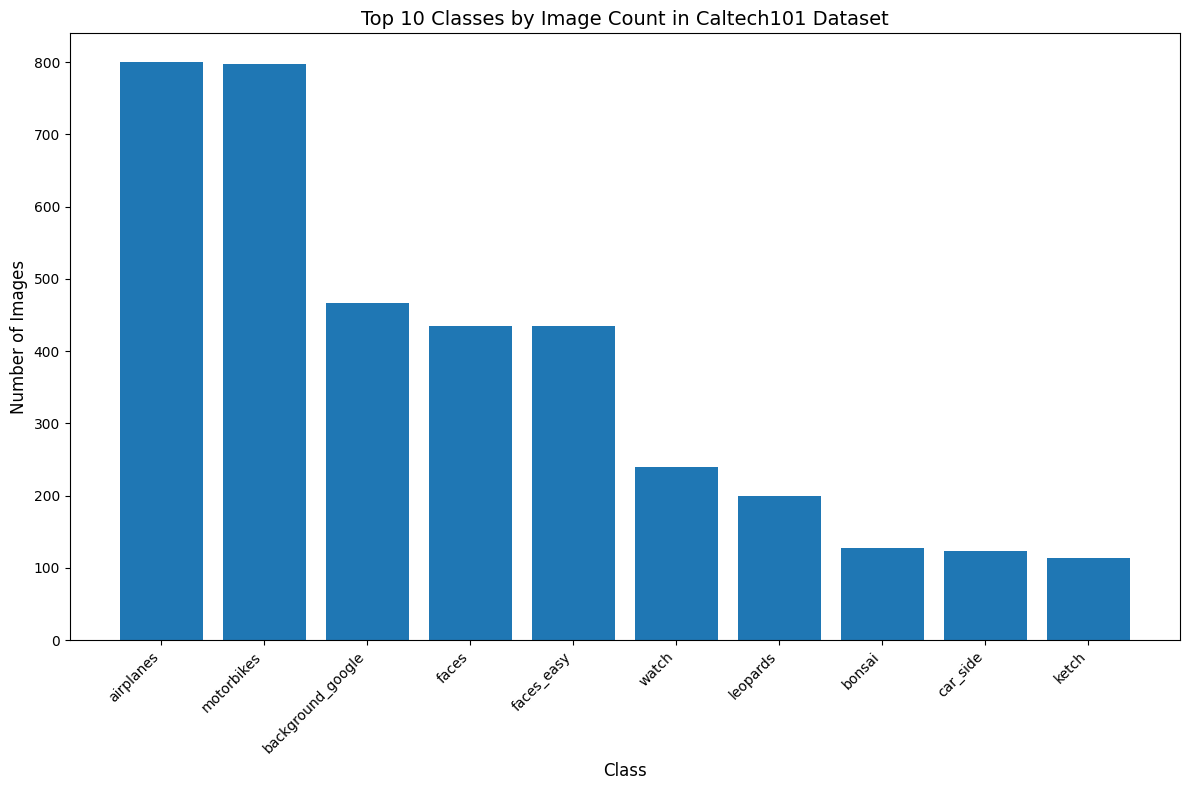

Total classes in dataset: 102
Total images in dataset: 9144


In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


BATCH_SIZE = 64
RANDOM_SEED = 555
IMAGE_SIZE = 96
LATENT_DIM = 128

# Load the Caltech101 dataset with train and test splits
caltech101 = tfds.load('caltech101', split=['train', 'test'], as_supervised=True)
train_ds, test_ds = caltech101[0], caltech101[1]

# Combine train and test datasets
combined_ds = train_ds.concatenate(test_ds)

# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {}
    for image, label in dataset:
        if label.numpy() in class_counts:
            class_counts[label.numpy()] += 1
        else:
            class_counts[label.numpy()] = 1
    return class_counts

# Count images in combined dataset
combined_counts = count_images_per_class(combined_ds)

# Get class names from the dataset info
ds_info = tfds.builder('caltech101').info
class_names = ds_info.features['label'].names

# Create a DataFrame for visualization
data = {
    'class': [i for i in combined_counts.keys()],
    'class_name': [class_names[i] for i in combined_counts.keys()],
    'count': list(combined_counts.values())
}
df = pd.DataFrame(data)

# Sort by count and get top 10
top10_df = df.sort_values('count', ascending=False).head(10)

# Create bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.8
index = np.arange(len(top10_df))

plt.bar(index, top10_df['count'], bar_width)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Top 10 Classes by Image Count in Caltech101 Dataset', fontsize=14)
plt.xticks(index, top10_df['class_name'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total classes in dataset: {len(class_names)}")
print(f"Total images in dataset: {sum(combined_counts.values())}")


In [2]:
## Preprocessing
@tf.function
def scale_resize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # Resizing the image to 224x224 dimention
    return (image, label)

combined_ds = combined_ds.filter(lambda _, label: label == 1 or label == 66 or label == 95)
combined_ds = (combined_ds.map(scale_resize_image))


2025-03-21 17:10:47.599965: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


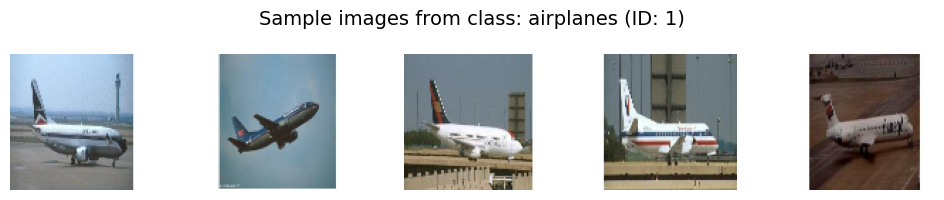

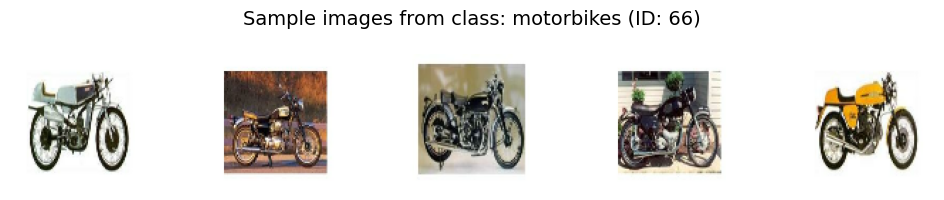

In [3]:
# Display sample images from specific classes
def show_class_samples(dataset, class_id, class_name, num_samples=5):
    # Filter dataset for the specific class
    class_ds = dataset.filter(lambda image, label: label == class_id)
    
    # Take the specified number of samples
    samples = list(class_ds.take(num_samples).as_numpy_iterator())
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    fig.suptitle(f'Sample images from class: {class_name} (ID: {class_id})', fontsize=14)
    
    # Display each sample
    for i, (image, _) in enumerate(samples):
        if i < num_samples:
            axes[i].imshow(image)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from class 1 (airplane)
show_class_samples(combined_ds, 1, class_names[1])

# Show samples from class 66 (motorcycle)
show_class_samples(combined_ds, 66, class_names[66])


In [4]:
# Map the dataset to use images as both input and target, then batch it
train_ds = combined_ds.filter(lambda _, label: label == 1 or label == 66).map(lambda image, label: image).cache()
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds = train_ds.cache()
# Fix the cardinality of the dataset after filtering
train_ds = train_ds.apply(tf.data.experimental.assert_cardinality(sum(1 for _ in train_ds)))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Map the dataset to use images as both input and target, then batch it
anomaly_ds = combined_ds.filter(lambda _, label: label != 1 and label != 66).map(lambda image, label: image).cache()
anomaly_ds = anomaly_ds.shuffle(buffer_size=1024)
anomaly_ds = anomaly_ds.cache()
# Fix the cardinality of the dataset after filtering
anomaly_ds = anomaly_ds.apply(tf.data.experimental.assert_cardinality(sum(1 for _ in anomaly_ds)))
anomaly_ds = anomaly_ds.batch(BATCH_SIZE)
anomaly_ds = anomaly_ds.prefetch(tf.data.AUTOTUNE)


2025-03-21 17:10:48.067298: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Build the encoder
def build_vanilla_encoder(input_shape, latent_dim):
    encoder_inputs = keras.Input(shape=input_shape)
    
    # Same structure as VAE encoder
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    
    # Simple deterministic latent vector
    latent = layers.Dense(latent_dim, name="latent_vector")(x)
    
    encoder = keras.Model(encoder_inputs, latent, name="vanilla_encoder")
    return encoder

def build_vanilla_decoder(latent_dim, output_shape):
    h, w, c = output_shape
    encoder_conv_layers = 3
    decoder_starting_dims = (h // (2 ** encoder_conv_layers), w // (2 ** encoder_conv_layers), 128)
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(decoder_starting_dims), activation="relu")(latent_inputs)
    x = layers.Reshape(decoder_starting_dims)(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    
    decoder_outputs = layers.Conv2D(c, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="vanilla_decoder")
    return decoder

# Build the Autoencoder model
class Autoencoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker]
    
    def train_step(self, data):
        x = data
        
        with tf.GradientTape() as tape:
            # Encode
            latent = self.encoder(x)
            # Decode
            reconstruction = self.decoder(latent)
            # Calculate MSE loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(x - reconstruction),  # Manual MSE calculation
                    axis=(1, 2)
                )
            )
            # For vanilla autoencoder, total loss is just reconstruction loss
            total_loss = reconstruction_loss
        
        # Get gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metric
        self.total_loss_tracker.update_state(total_loss)
        
        return {
            "loss": self.total_loss_tracker.result()
        }
        
    def call(self, inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

# Main training function
def train_autoencoder(dataset, img_shape=(224, 224, 3), latent_dim=64, epochs=20, learning_rate=0.001):
    # Build models
    encoder = build_vanilla_encoder(img_shape, latent_dim)
    decoder = build_vanilla_decoder(latent_dim, img_shape)
    
    # Create Autoencoder
    autoencoder = Autoencoder(encoder, decoder)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    
    # Train the model
    history = autoencoder.fit(dataset, epochs=epochs, verbose=1)
    
    return autoencoder, history, encoder, decoder

# Generate reconstructions from the autoencoder
def generate_reconstructions(autoencoder, test_images, n=10):
    # Get test images
    test_sample = test_images[:n]
    # Get reconstructions
    reconstructed = autoencoder.predict(test_sample)
    
    return test_sample, reconstructed

# Visualize original vs reconstructed images
def visualize_reconstructions(originals, reconstructions, n=10):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

In [6]:
# Build the encoder
def build_vae_encoder(input_shape, latent_dim):
    encoder_inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    
    # VAE specific: output mean and log variance
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    # Use sampling trick for backpropagation
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="vae_encoder")
    return encoder


# Build the decoder
def build_vae_decoder(latent_dim, output_shape):
    h, w, c = output_shape
    encoder_conv_layers = 3
    decoder_starting_dims = (h // (2 ** encoder_conv_layers), w // (2 ** encoder_conv_layers), 128)
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(decoder_starting_dims), activation="relu")(latent_inputs)
    x = layers.Reshape(decoder_starting_dims)(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    
    decoder_outputs = layers.Conv2D(c, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="vae_decoder")
    return decoder

# Build the VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        x = data
        
        with tf.GradientTape() as tape:
            # Encode
            z_mean, z_log_var, z = self.encoder(x)
            # Decode
            reconstruction = self.decoder(z)
            # Calculate losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(x - reconstruction),  # MSE calculation
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        # Get gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)
        
# Main training function
def train_vae(dataset, img_shape=(224, 224, 3), latent_dim=64, epochs=20, learning_rate=0.001):
    # Build models
    encoder = build_vae_encoder(img_shape, latent_dim)
    decoder = build_vae_decoder(latent_dim, img_shape)
    
    # Create VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    
    # Train the model
    history = vae.fit(dataset, epochs=epochs, verbose=1)
    
    return vae, history

# Generate reconstructions from the VAE
def generate_vae_reconstructions(vae, test_images, n=10):
    # Get test images
    test_sample = test_images[:n]
    
    # For VAE, we need to get the latent representation first
    z_mean, z_log_var, z = vae.encoder(test_sample)
    
    # Generate reconstructions using the decoder
    reconstructed = vae.decoder(z)
    
    return test_sample, reconstructed

def visualize_vae_reconstructions(originals, reconstructions, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(originals))):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()


Epoch 1/20


2025-03-21 17:10:49.289773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 846.2176
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 584.4678
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 508.0744
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 444.7380
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 420.1019
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 404.3215
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 379.0008
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 334.4473
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 313.2057
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 296.9122
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 280.6052
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 274.5805
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 274.8923
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 261.8860
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - 

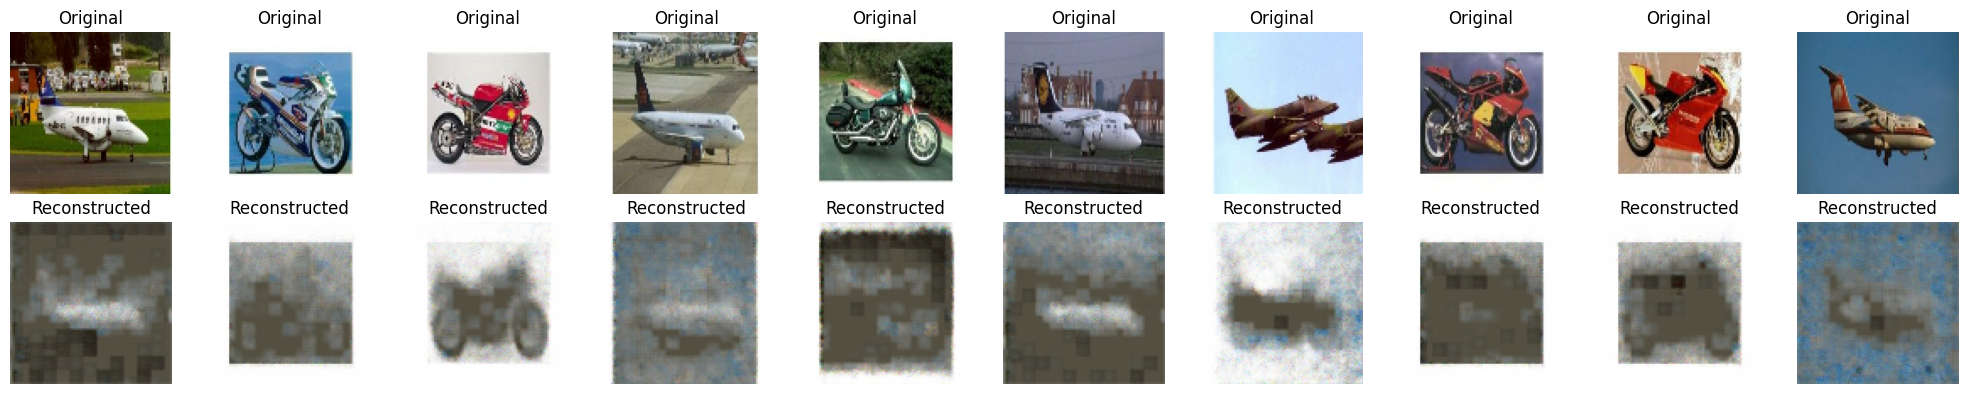

In [7]:
# 3. Train VAE
autoencoder, history, encoder, decoder = train_autoencoder(train_ds, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIM, epochs=20)

test_image = [image for image in train_ds.take(1)][0]
original, reconstructed = generate_reconstructions(autoencoder, test_image, n=10)
visualize_reconstructions(original, reconstructed, n=10)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - kl_loss: 14.5881 - loss: 6213.2515 - reconstruction_loss: 6198.6641
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - kl_loss: 111.1402 - loss: 5704.2837 - reconstruction_loss: 5593.1436
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - kl_loss: 45.2154 - loss: 5305.6216 - reconstruction_loss: 5260.4062
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - kl_loss: 45.8364 - loss: 5123.9829 - reconstruction_loss: 5078.1465
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - kl_loss: 52.5655 - loss: 5067.2539 - reconstruction_loss: 5014.6885
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - kl_loss: 56.3298 - loss: 5029.4238 - reconstruction_loss: 4973.0942
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - kl_loss: 52.6727 - loss: 4981.0913 - reconstruction_loss: 4928.4185
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - kl_loss: 59.9166 - loss: 4947.9053 - reconstruction_loss: 4887.9883
Epoch 9/20
25/25 ━━━━━━━━━━━━━━

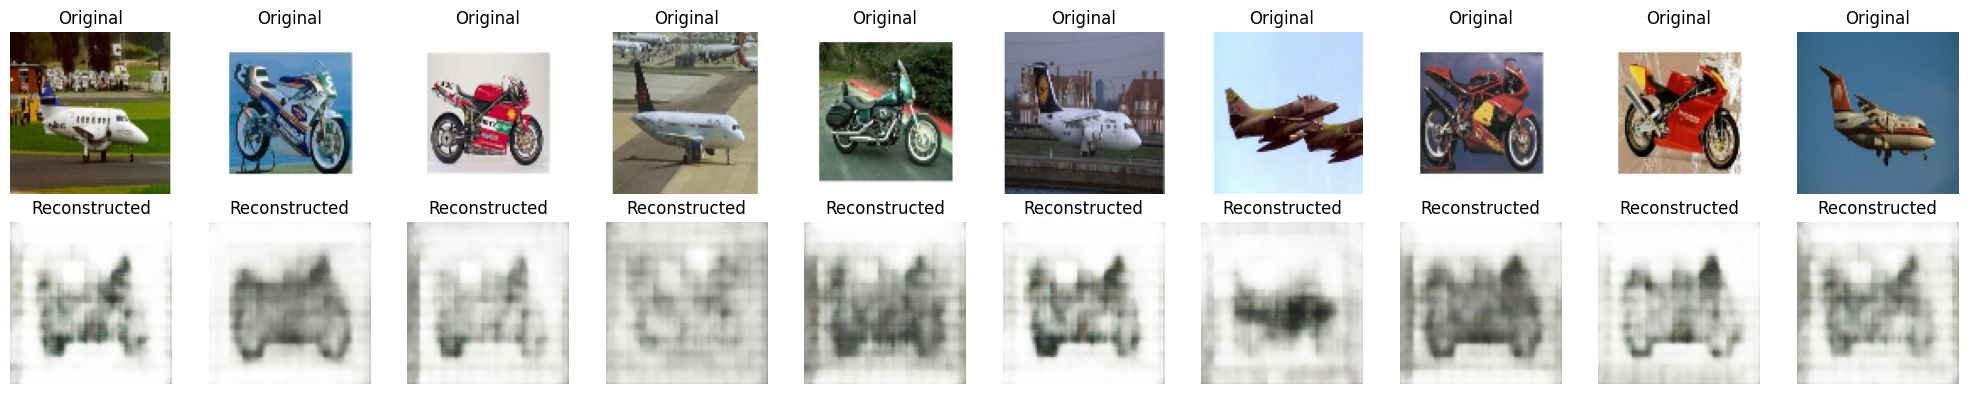

In [8]:
test_image = [image for image in train_ds.take(1)][0]
vae, history = train_vae(train_ds, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIM, epochs=20)
original, reconstructed = generate_vae_reconstructions(vae, test_image, n=10)
visualize_vae_reconstructions(original, reconstructed, n=10)

(64, 96, 96, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


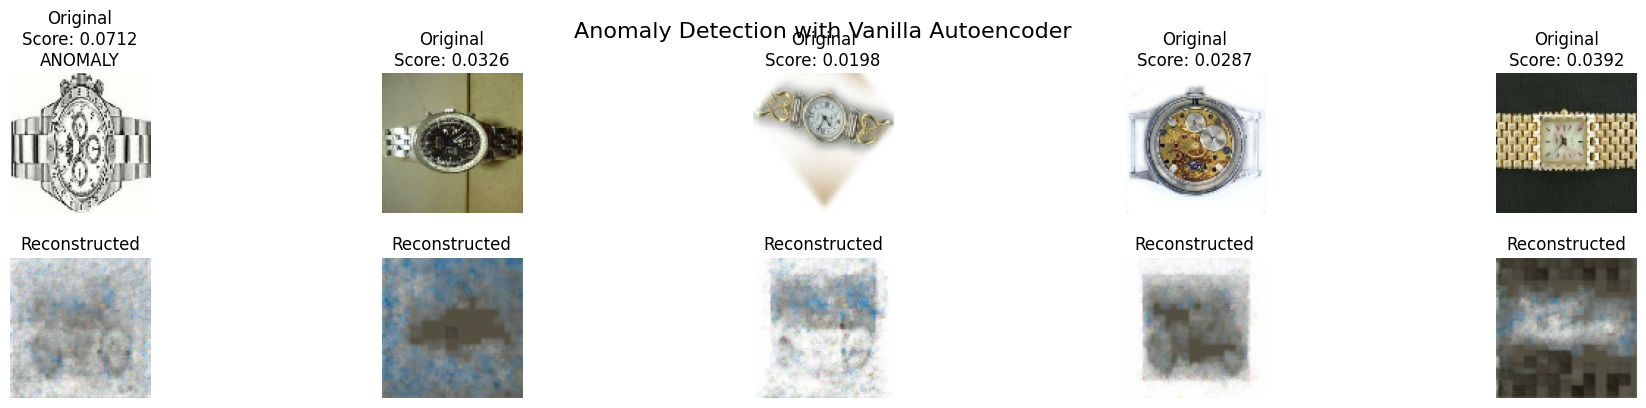

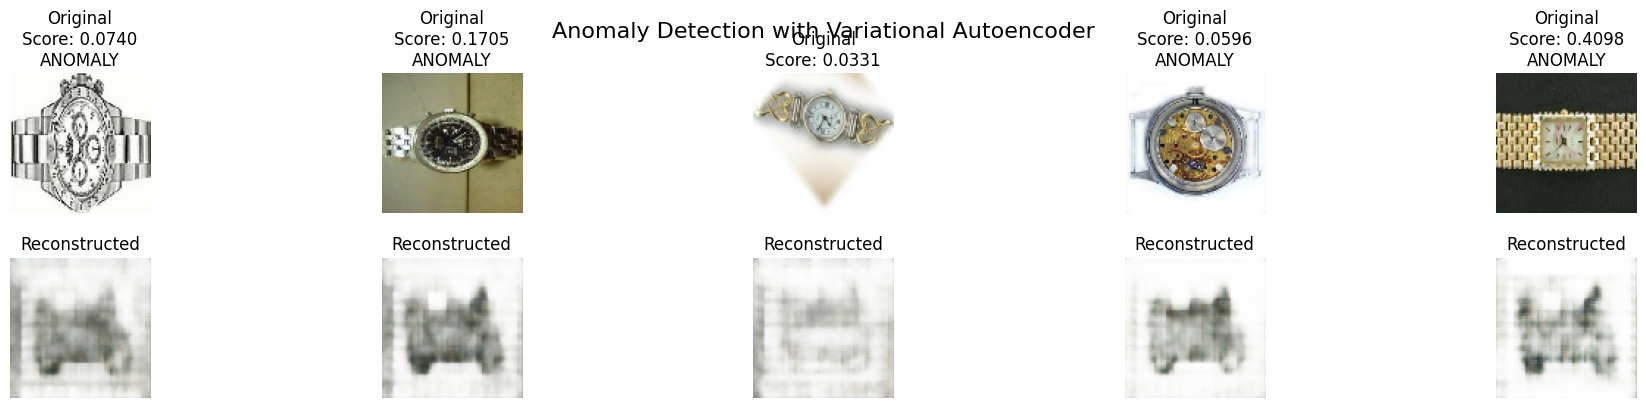

Vanilla Autoencoder detected 38 anomalies
VAE detected 61 anomalies
Correlation between anomaly scores: 0.3024


In [10]:
# 4. Visualize anomaly detection capabilities

def detect_anomalies_autoencoder(autoencoder, images, threshold=0.1):
    """
    Detect anomalies using a regular autoencoder by measuring reconstruction error.
    
    Args:
        autoencoder: Trained autoencoder model
        images: Images to check for anomalies
        threshold: Threshold for anomaly detection
        
    Returns:
        List of anomaly scores and boolean indicators for anomalies
    """
    reconstructions = autoencoder.predict(images)
    
    # Calculate MSE for each image
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))
    
    # Determine if each image is an anomaly based on threshold
    anomalies = mse > threshold
    
    return mse, anomalies, reconstructions

def detect_anomalies_vae(vae, images, threshold=0.1):
    """
    Detect anomalies using a VAE by measuring reconstruction error.
    
    Args:
        vae: Trained VAE model
        images: Images to check for anomalies
        threshold: Threshold for anomaly detection
        
    Returns:
        List of anomaly scores and boolean indicators for anomalies
    """
    # Get latent representation
    z_mean, z_log_var, z = vae.encoder(images)
    
    # Generate reconstructions
    reconstructions = vae.decoder(z)
    
    # Calculate MSE for each image
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))
    
    # Determine if each image is an anomaly based on threshold
    anomalies = mse > threshold
    
    return mse, anomalies, reconstructions

def visualize_anomalies(original_images, reconstructions, scores, anomalies, model_name, n=5):
    """
    Visualize original images, reconstructions, and highlight anomalies.
    
    Args:
        original_images: Original input images
        reconstructions: Reconstructed images from the model
        scores: Anomaly scores
        anomalies: Boolean indicators for anomalies
        model_name: Name of the model (for title)
        n: Number of images to display
    """
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(original_images))):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        title = f"Original\nScore: {scores[i]:.4f}"
        if anomalies[i]:
            title += "\nANOMALY"
            plt.gca().spines['bottom'].set_color('red')
            plt.gca().spines['top'].set_color('red') 
            plt.gca().spines['right'].set_color('red')
            plt.gca().spines['left'].set_color('red')
            plt.gca().spines['bottom'].set_linewidth(2)
            plt.gca().spines['top'].set_linewidth(2) 
            plt.gca().spines['right'].set_linewidth(2)
            plt.gca().spines['left'].set_linewidth(2)
        plt.title(title)
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.suptitle(f"Anomaly Detection with {model_name}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Get a batch of test images
test_batch = [image for image in anomaly_ds.take(1)][0]
print(test_batch.shape)

# Set a threshold for anomaly detection
threshold = 0.05

# Detect anomalies with regular autoencoder
ae_scores, ae_anomalies, ae_reconstructions = detect_anomalies_autoencoder(autoencoder, test_batch, threshold)
visualize_anomalies(test_batch, ae_reconstructions, ae_scores, ae_anomalies, "Vanilla Autoencoder")

# Detect anomalies with VAE
vae_scores, vae_anomalies, vae_reconstructions = detect_anomalies_vae(vae, test_batch, threshold)
visualize_anomalies(test_batch, vae_reconstructions, vae_scores, vae_anomalies, "Variational Autoencoder")

# Compare the anomaly detection results
print(f"Vanilla Autoencoder detected {np.sum(ae_anomalies)} anomalies")
print(f"VAE detected {np.sum(vae_anomalies)} anomalies")

# Print correlation between anomaly scores from both models
correlation = np.corrcoef(ae_scores, vae_scores)[0, 1]
print(f"Correlation between anomaly scores: {correlation:.4f}")
